# Marketing Mix Modeling (MMM) for Rossmann Sales

## Overview
This notebook implements a **Marketing Mix Model (MMM)** using Bayesian hierarchical modeling. Building on established baseline sales, we quantify the incremental impact of promotions (`Promo` and `Promo2`) and simulate future sales trajectories under planned marketing calendars.

## Key Objectives
1. **Hierarchical Modeling**: Estimate store-specific effects of promotional depth (Discount Intensity).
2. **Incremental Lift**: Calculate exactly how many units were sold due to marketing vs. organic demand.
3. **Decomposition**: Visualize sales as a combination of baseline and incremental layers.
4. **Future Simulation**: Forecast sales for the remainder of 2015 based on hypothetical promo schedules.
5. **Optimal Promotions**: Best way to run promo schedules

---

## 1. Environment Setup
We import standard analytical libraries and our custom Bayesian utility module. We also configure `pytensor` to optimize performance.

In [1]:
import numpy as np
import pandas as pd
import os
import cloudpickle
import json

# Specific flags for pytensor optimizations
os.environ["PYTENSOR_FLAGS_CXX"] = "g++"
os.environ["PYTENSOR_FLAGS"] = "optimizer_excluding=local_subtensor_merge"

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline
import bayesian_utils as bbu  # Custom utility module
import logging

# Suppress PyMC progress bars and sampling messages
logging.getLogger("pymc").setLevel(logging.ERROR)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")

c:\Users\SolaiVenkatesanManog\projects\kaggle\MMM\.venv\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Bayesian module loaded successfully!
PyMC version: 5.27.0
ArviZ version: 0.23.0


## 2. Data Loading & Filtering
We load the baseline-enriched dataset. To ensure a robust MMM, we focus on stores where the actual sales exceeded the predicted baseline (indicating measurable promotional lift).

In [2]:
df_final = pd.read_csv(r"C:\Users\SolaiVenkatesanManog\projects\kaggle\MMM\baseline_predictions_with_lift_23.csv")

store_comp = (
    df_final.groupby('Store')[['Sales', 'baseline_mean']]
      .sum()
)

stores_baseline = store_comp[
    store_comp['baseline_mean'] < store_comp['Sales']
].index
# print(stores_baseline.tolist())
df_model = df_final[df_final.Store.isin(stores_baseline)]

## 3. MMM Data Preparation
We use `prepare_mmm_df` to transform the filtered dataset for Marketing Mix Modeling.

In [3]:
df_mmm, stores_mmm = bbu.prepare_mmm_df(df_model)

## 4. Modeling Pipeline
We extract the required arrays and fit the hierarchical Marketing Mix Model. This model accounts for store-level variation in promo effectiveness while sharing information across the network (partial pooling).

In [ ]:
y, baseline_log, di, store_idx, dow_idx, month_idx, state_h, school_h, log_comp = mmm_arrays = bbu.build_mmm_arrays(df_mmm)

model_mmm, idata_mmm = bbu.fit_mmm_pymc(
    y, baseline_log, di, store_idx, dow_idx, month_idx, state_h, school_h, log_comp, 
    S=stores_mmm, draws=1000, tune=1000, chains=4, random_seed=123
)

## 5. Model Persistence
We save the model trace and metadata for future use and reproducibility.

In [ ]:
az.to_netcdf(idata_mmm, "mmm_trace.nc")
with open("model_mmm.pkl", "wb") as f:
    cloudpickle.dump(model_mmm, f)

metadata = {
    "draws": 1000,
    "tune": 1000,
    "chains": 4,
    "target_accept": 0.9,
    "stores": int(stores_mmm),
    "pymc_version": pm.__version__,
}

with open("mmm_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)


### Load Pretrained model (Uncomment if needed)

In [ ]:
# idata_mmm = az.from_netcdf("trace_mmm.nc")
# with open("model_mmm.pkl", "rb") as f:
#     model_mmm = cloudpickle.load(f)

## 6. Incremental Sales Analysis
Using the trained model, we run a posterior predictive check under two scenarios:
1. **Factual**: Promos as they actually occurred.
2. **Counterfactual**: Promotions entirely removed (Discount Intensity = 0).

The difference represents the **Incremental Sales** generated by marketing.

In [5]:
# --- Factual: promo as observed ---
with model_mmm:
    pm.set_data({"DI": df_mmm["discount_intensity"].values.astype(float)})
    pp_factual = pm.sample_posterior_predictive(idata_mmm, var_names=["y_obs"], random_seed=123, progressbar=False)

# --- Counterfactual: no promo (DI=0) ---
with model_mmm:
    pm.set_data({"DI": np.zeros_like(df_mmm["discount_intensity"].values)})
    pp_counterfactual = pm.sample_posterior_predictive(idata_mmm, var_names=["y_obs"], random_seed=123, progressbar=False)

# Convert back to sales scale
sales_factual = np.exp(pp_factual.posterior_predictive["y_obs"].values) - 1
sales_counterfactual = np.exp(pp_counterfactual.posterior_predictive["y_obs"].values) - 1

# Compute incremental sales
incremental_sales = sales_factual - sales_counterfactual

## 7. Global Sales Visualization
We visualize the total network sales, comparing actual values vs. factual predictions vs. organic baseline.

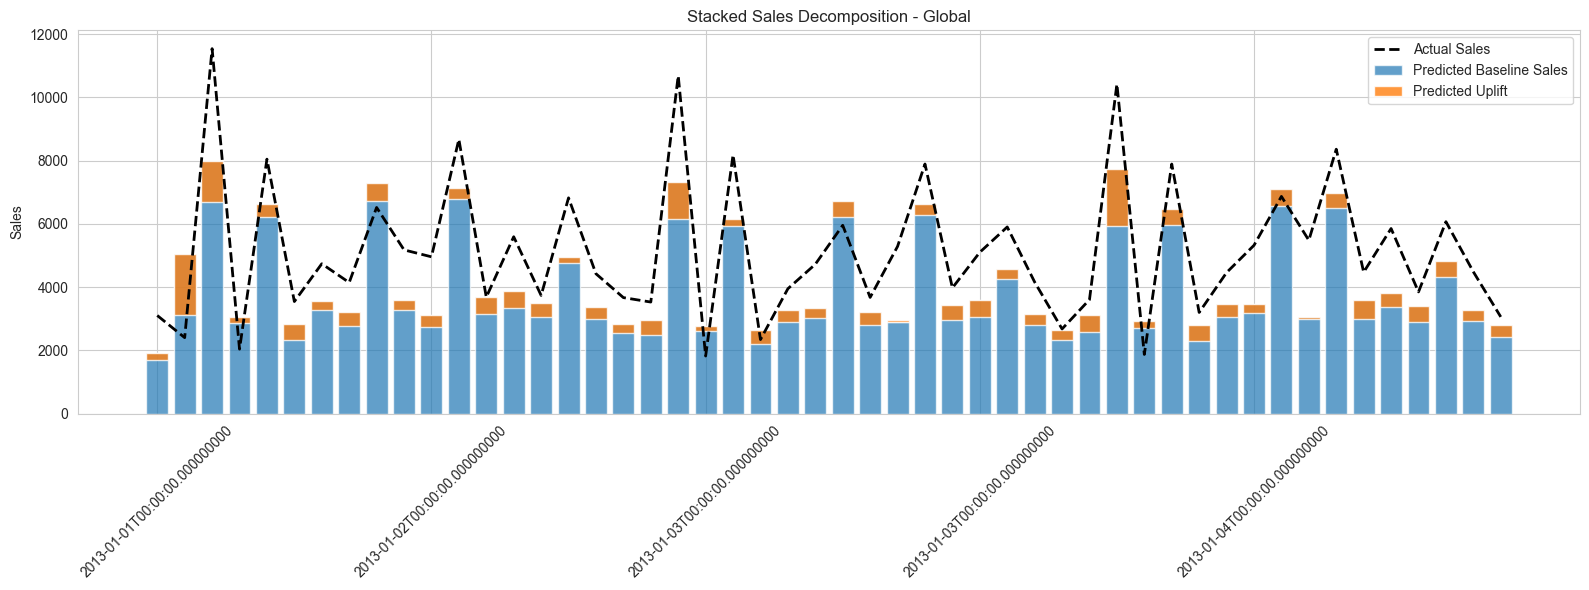

In [6]:
# Filter store, sort by date, take top 200
df_plot = (
    df_mmm[
        ((df_mmm["Promo"] == 1) | (df_mmm["Promo2"] == 1))
    ]
    .sort_values("Date")
    .head(50)
)


# Position indices in original df_mmm
positions = np.searchsorted(df_mmm.index.to_numpy(), df_plot.index.to_numpy())

dates = df_plot["Date"].values
actual_sales = df_plot["Sales"].values
baseline_sales = df_plot["baseline_mean"].values
baseline_sales = baseline_sales.reshape(1, -1)

# Flatten posterior
chains, draws, _ = sales_factual.shape
factual_store = sales_factual[:, :, positions].reshape(chains * draws, -1)
counterfactual_store = sales_counterfactual[:, :, positions].reshape(chains * draws, -1)
baseline_sales = np.broadcast_to(
    baseline_sales,
    factual_store.shape
)


# Incremental sales posterior
# incremental_store = factual_store - counterfactual_store
incremental_store = factual_store - baseline_sales


def summarize(samples):
    return (
        np.median(samples, axis=0),
        np.percentile(samples, 2.5, axis=0),
        np.percentile(samples, 97.5, axis=0),
    )

cf_med, cf_lo, cf_hi = summarize(counterfactual_store)
inc_med, inc_lo, inc_hi = summarize(incremental_store)
baseline_med, baseline_lo, baseline_hi = summarize(baseline_sales)
x = np.arange(len(dates))
bar_width = 0.8


plt.figure(figsize=(16,6))

# Bottom bar: counterfactual
plt.bar(
    x,
    cf_med,
    width=bar_width,
    label="Predicted Baseline Sales",
    alpha=0.7
)

# Top bar: incremental promo lift
plt.bar(
    x,
    inc_med,
    bottom=cf_med,
    width=bar_width,
    label="Predicted Uplift",
    alpha=0.8
)

# Actual sales overlay
plt.plot(
    x,
    actual_sales,
    color="black",
    linestyle="--",
    linewidth=2,
    label="Actual Sales"
)

plt.xticks(x[::10], dates[::10], rotation=45)
plt.ylabel("Sales")
plt.title(f"Stacked Sales Decomposition - Global")
plt.legend()
plt.tight_layout()
plt.show()


## 8. Store-Level Performance
Detailed analysis for a sample store (Store 82), highlighting the lift period.

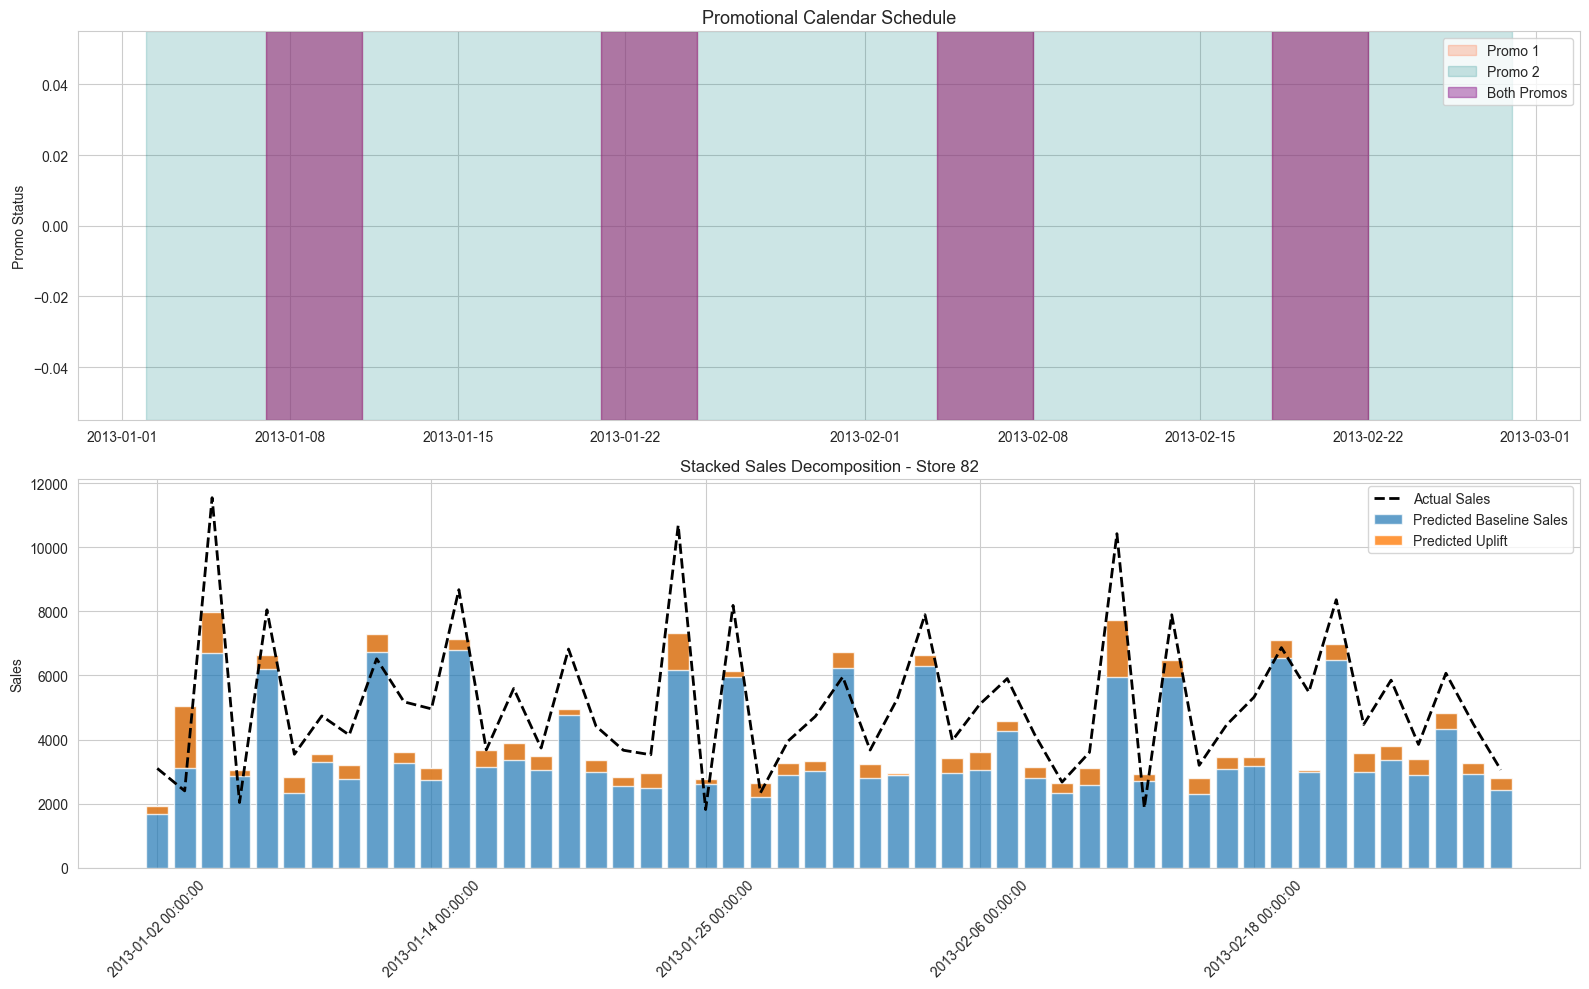

In [7]:
# Filter store, sort by date, take top 200
store_to_plot = 82
df_store = (
    df_mmm[
        (df_mmm["Store"] == 82)
        & ((df_mmm["Promo"] == 1) | (df_mmm["Promo2"] == 1))
    ]
    .sort_values("Date")
    .head(50)
)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
dates = df_store['Date']

# Top plot: Promo schedule
ax1.fill_between(dates, 0, 1, where=(df_store['Promo'] == 1), 
                    color='coral', alpha=0.3, label='Promo 1', 
                    step='post', transform=ax1.get_xaxis_transform())
ax1.fill_between(dates, 0, 1, where=(df_store['Promo2'] == 1), 
                    color='teal', alpha=0.2, label='Promo 2', 
                    step='post', transform=ax1.get_xaxis_transform())
overlap = (df_store['Promo'] == 1) & (df_store['Promo2'] == 1)
ax1.fill_between(dates, 0, 1, where=overlap, 
                    color='purple', alpha=0.4, label='Both Promos', 
                    step='post', transform=ax1.get_xaxis_transform())
ax1.set_title('Promotional Calendar Schedule', fontsize=13)
ax1.legend(loc='upper right')
ax1.set_ylabel('Promo Status')

x = np.arange(len(dates))

# Baseline (counterfactual)
ax2.bar(
    x,
    cf_med,
    width=0.8,
    label="Predicted Baseline Sales",
    alpha=0.7
)

# Incremental uplift
ax2.bar(
    x,
    inc_med,
    bottom=cf_med,
    width=0.8,
    label="Predicted Uplift",
    alpha=0.8
)

# Actual sales
ax2.plot(
    x,
    actual_sales,
    color="black",
    linestyle="--",
    linewidth=2,
    label="Actual Sales"
)

ax2.set_xticks(x[::10])
ax2.set_xticklabels(dates[::10], rotation=45)
ax2.set_ylabel("Sales")
ax2.set_title("Stacked Sales Decomposition - Store 82")
ax2.legend()

plt.tight_layout()
plt.show()

## 9. Forecasting Simulation
Finally, we simulate sales for the two months in second half of 2015.   
This is the most critical business use case: predicting the ROI of future marketing investments.

### 9.1 Create the future Calendar (2 months)

In [8]:
# Build Future Calendar
df_simulation = bbu.build_future_calendar(
    start_date=pd.Timestamp("2015-07-31"),
    end_date=pd.Timestamp("2015-09-30"),
    store_id=82,
    store_idx=0,
)
# Sample Holidays from last year for store 82
df_simulation = bbu.map_last_year_holidays(df_simulation, df_mmm, 82)
# Add Baseline to Future Calendar
df_simulation["baseline_mean"] = bbu.forecast_baseline_spline(
    df=df_mmm[df_mmm["Store"] == 82],
    forecast_dates=df_simulation["Date"],
)
df_simulation["baseline_log"] = np.log(df_simulation["baseline_mean"] + 1)
# Add Competition Distance to Future Calendar
df_simulation["log_comp_dist"] = df_mmm[df_mmm["Store"] == 82]["log_comp_dist"].iloc[-1]


### 9.2 Simulation to Run the Promotions

Optimizing calendar for Store 82 (30 iterations)...
Iteration  0: Total sales = 507,463
Iteration  0: Total Lift = 63,605
Iteration  1: Total sales = 527,911
Iteration  1: Total Lift = 83,992
Iteration  6: Total sales = 537,430
Iteration  6: Total Lift = 93,665

 Total sales: 537,430
 Total Lift = 93,665


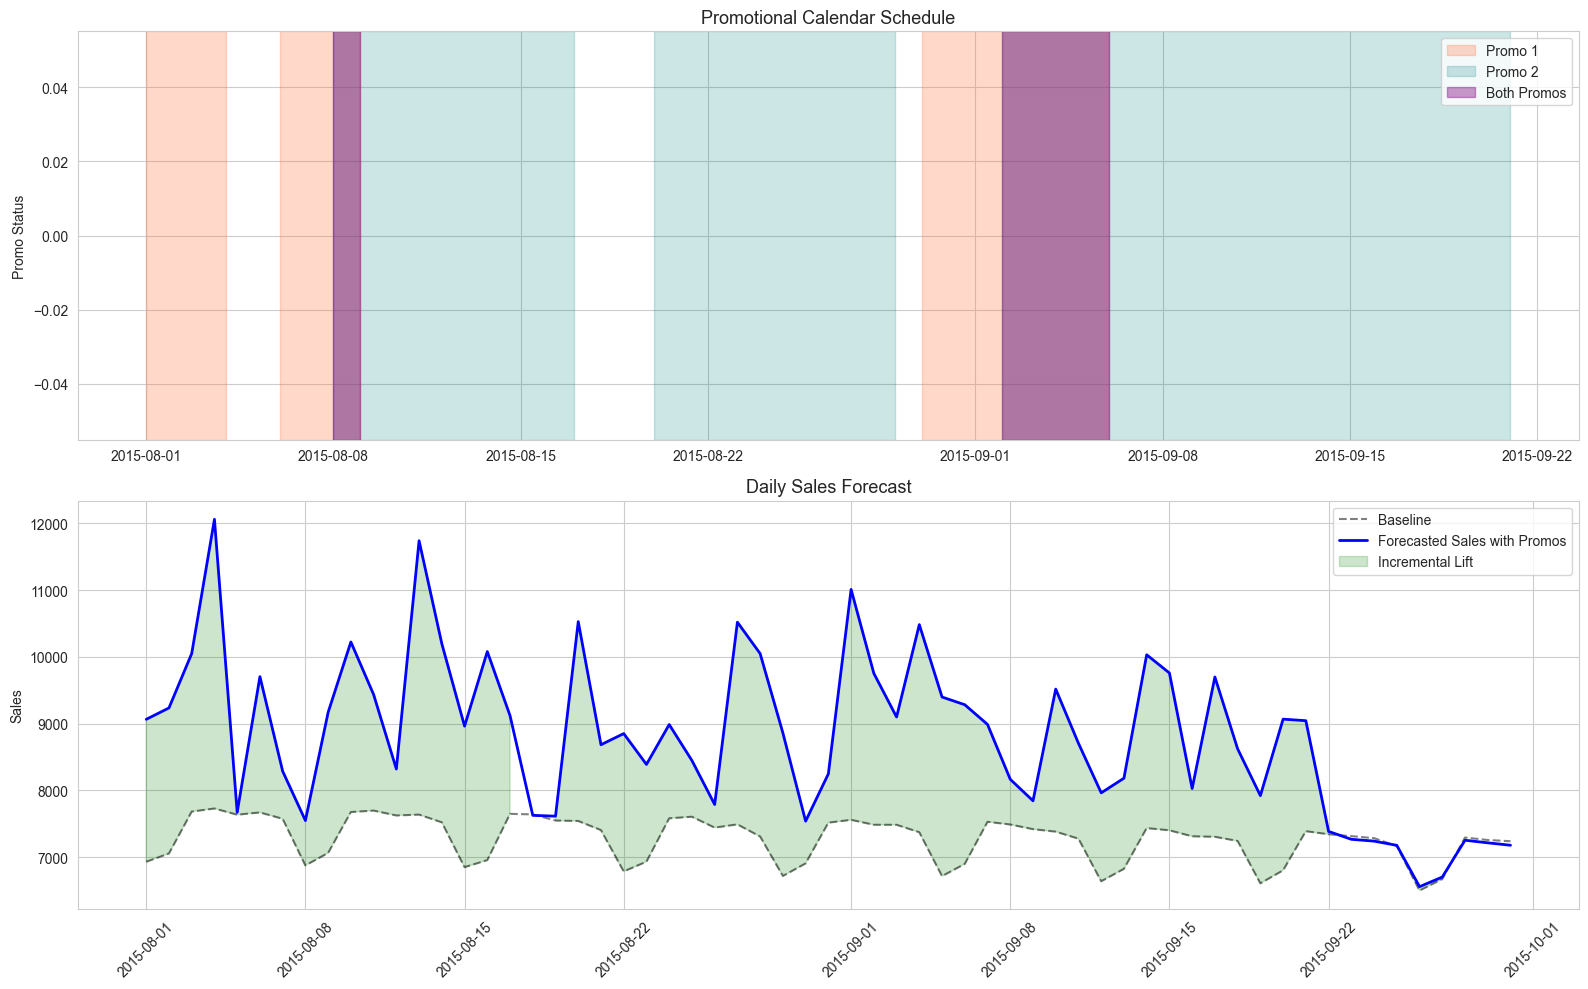

Summary:
Promo 1: 16 days
Promo 2: 40 days
Both Promos will run for : 7 days
Forecasted Total Sales: 537,430
Forecasted Total Sales (no promo): 443,765
Forecasted Avg Daily Sales: 8,810


In [9]:
iterations = 30
best_total_sales = 0
best_df = None
store_num = df_simulation['Store'].iloc[0]
n_p1 = 16
n_p2 = 50
len_p1 = 4
len_p2 = 10
print(f"Optimizing calendar for Store {store_num} ({iterations} iterations)...")

for i in range(iterations):
    df_sim = df_simulation.copy()
    
    # Assign promos
    df_sim = bbu.assign_promos(df_sim, n_p1, n_p2, len_p1, len_p2, seed=i*100)
    
    # Sample discount intensity
    df_sim = bbu.sample_discount_intensity(df_sim, df_mmm, store_num, seed=i*100)
    
    # Compute sales forecast (this adds the 'sales' column)
    df_sim = bbu.compute_sales_forecast(df_sim, model_mmm, idata_mmm)
    
    # Calculate TOTAL for comparison
    total_sales = df_sim['sales'].sum()
    
    if total_sales > best_total_sales:
        best_total_sales = total_sales
        best_df = df_sim.copy()
        best_incremental_sales = df_sim['incremental'].sum()
        print(f"Iteration {i:2d}: Total sales = {total_sales:,.0f}")
        print(f"Iteration {i:2d}: Total Lift = {best_incremental_sales:,.0f}")

print(f"\n Total sales: {best_total_sales:,.0f}")
print(f" Total Lift = {best_incremental_sales:,.0f}")
bbu.visualize_calendar(best_df)

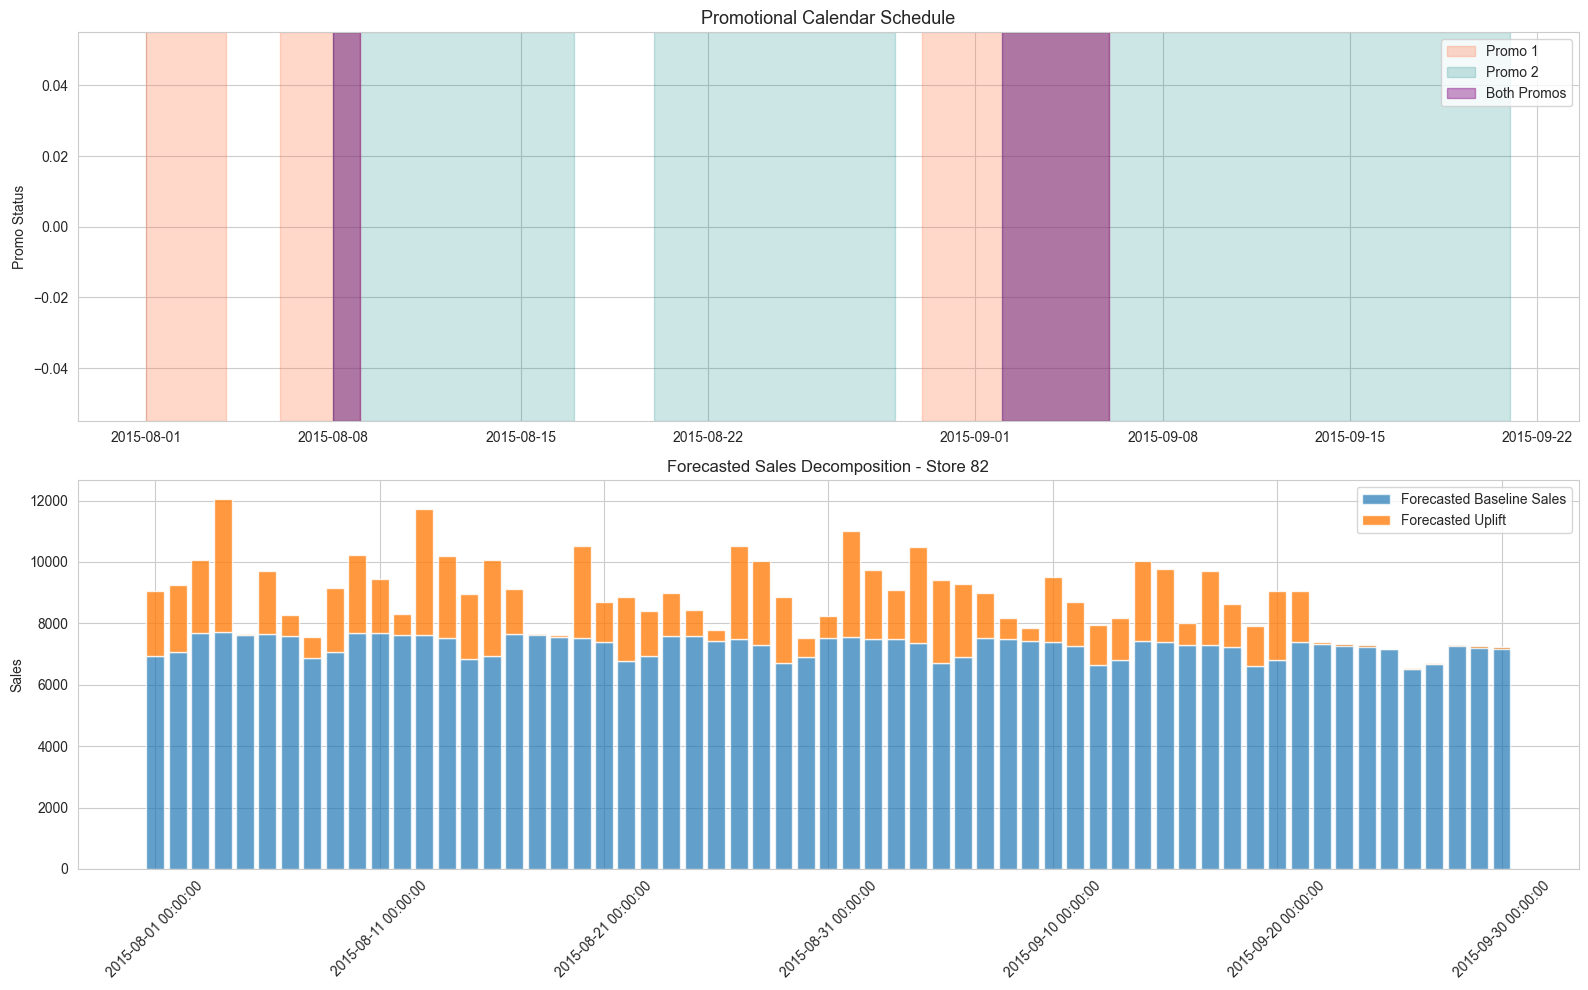

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
dates = best_df['Date']

# Top plot: Promo schedule
ax1.fill_between(dates, 0, 1, where=(best_df['promo'] == 1), 
                    color='coral', alpha=0.3, label='Promo 1', 
                    step='post', transform=ax1.get_xaxis_transform())
ax1.fill_between(dates, 0, 1, where=(best_df['promo2'] == 1), 
                    color='teal', alpha=0.2, label='Promo 2', 
                    step='post', transform=ax1.get_xaxis_transform())
overlap = (best_df['promo'] == 1) & (best_df['promo2'] == 1)
ax1.fill_between(dates, 0, 1, where=overlap, 
                    color='purple', alpha=0.4, label='Both Promos', 
                    step='post', transform=ax1.get_xaxis_transform())
ax1.set_title('Promotional Calendar Schedule', fontsize=13)
ax1.legend(loc='upper right')
ax1.set_ylabel('Promo Status')

x = np.arange(len(dates))

# Baseline (counterfactual)
ax2.bar(
    x,
    best_df['sales_no_promo'],
    width=0.8,
    label="Forecasted Baseline Sales",
    alpha=0.7
)

# Incremental uplift
ax2.bar(
    x,
    best_df['incremental'],
    bottom=best_df['sales_no_promo'],
    width=0.8,
    label="Forecasted Uplift",
    alpha=0.8
)



ax2.set_xticks(x[::10])
ax2.set_xticklabels(dates[::10], rotation=45)
ax2.set_ylabel("Sales")
ax2.set_title("Forecasted Sales Decomposition - Store 82")
ax2.legend()

plt.tight_layout()
plt.show()